In [1]:
import numpy as np
import pandas as pd
import scipy.stats as scs

np.random.seed(0)

import matplotlib.pyplot as plt

# Predictive Linear Regression

Brandon Martin-Anderson June 2019, with great debt to Moses Marsh, Matt Drury

### Learning goals

* Describe the essential aspects of a prediction task.
 * Why estimate?
 * How do we test a model?
* Describe MSE and its advantages
* Be able to quickly design a benchmark model.
* Describe the linear model in matrix- and non-matrix form.
* Describe open- and closed-form techniques for fitting linear models.
* Fit a linear model and evaluate its performance with and without `sklearn`.
* Use multiple features, categorical features, and engineered features.
* Pick polynomial regression order using cross-validation.

### The task of predicting quantities: in story form

Let's start a business: we estimate the fuel economy of cars. People describe a car and pay us money, and we tell them the fuel economy (in miles per gallon) of their car.

* The first customer comes in, and says, "This is a very competitive field. Why should we pay you?"
* You say, "We are very good at what we do."
* They say, "Your competitor says the same thing. Do you have evidence?"

Note two things.
1. **You are competing against other models.**
2. **Your model will be evaluated quantitatively.**

So you say: "We have analyzed all of our competitors's predictions. All their predictions have some error; the mean of their predictive errors is 5 mpg. We can do better."

* Them: "Ah, interesting. Prove it."
* You: "Describe a car."
* Them: "A 2020 hybrid Ford F250"
* You: "Can't predict - that **that car isn't in our records**"
* Them: "What good is that?"
* You: "If you ask about an old car, we can predict it perfectly."
* Them: "And...why would we pay for that?"
* You: "I don't know, but we are perfect."
* Them: "We'll go to your competitor instead."


3. **The only performance that matters is predictive performance on unseen examples.**



### The task of predicting quantities: in math form

There exists a quantitative response $Y$ (e.g., fuel economy) which is equal to the function of some properties $X$ (e.g., properties of cars) plus irreducable noise $\epsilon$ (e.g., manufacturing errors, vehicle wear, variations in vehicle usage).

$$Y = f(X) + \epsilon$$

The function $f(X)$ is generally known only to Nature - it is almost always hidden from us.

It is often possible to obtain a specific $y_i = f(x_i)$ through a relatively expensive process (e.g., building a car with certain properties and then driving it around and measuring its fuel economy). Instead of engaging in an expensive process, we're interested in finding an estimate $\hat{Y}$ using a _predictive model_ $\hat{f}$:

$$\hat{Y} = \hat{f}(X)$$

In contrast to $f$, $\hat{f}$ is known to us, because it's a function that we choose.

The formal goal of prediction is to find $\hat{f}$ that **minimizes some error function $E(Y, \hat{Y})$ on a collection of samples $X$ hidden when $\hat{f}$ is chosen.**

In the example above, $E$ was simply the mean absolute difference

$$E(Y, \hat{Y}) = \frac{\sum_{i=1}^{n}{|y_i - \hat{y_i}|}}{n}$$

The choice of error function (often called _loss_) is ultimately chosen to model the business logic of the prediction task, but probaby the most common is the _mean square error_:

$$E(Y, \hat{Y}) = \frac{\sum_{i=1}^{n}{(y_i - \hat{y_i})^2}}{n}$$

For a number of reasons, chiefly:
* It's convex.
* It's decomposable into bias, variance, and irreduceable error terms.
* There exists a closed form solution to minimize it in the case of a linear $\hat{f}$.

That last one is _extremely convenient_. It's why we're talking about linear regression today.



## A very simple predictive model

We wish to devise a predictive model $\hat{f}$ for our fuel-economy-estimation business. We start with a CSV we found on the internet.

In [2]:
cars = pd.read_csv("data/cars.csv", na_values=["?"])

In [3]:
cars = cars.dropna()

In [4]:
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Let's start with a very simple model: **always predict the average mpg**.

## Evaluating our model

Let's evaluate our model.

Because our metric for success is performance on unseen data, we need to keep some our data unseen.

In [5]:
n = len(cars)
n_holdout = int(n*0.2)
print( f"{n} records total, holding out {n_holdout}" )

392 records total, holding out 78


Shuffle the cars; or else we'd learn just about the 8-cylinder cars...

In [6]:
cars = cars.sample(len(cars))
cars_test = cars.iloc[:n_holdout]
cars_train = cars.iloc[n_holdout:]

In [7]:
cars_train.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
216,31.5,4,98.0,68.0,2045.0,18.5,77,3,honda accord cvcc
220,33.5,4,85.0,70.0,1945.0,16.8,77,3,datsun f-10 hatchback
256,20.5,6,225.0,100.0,3430.0,17.2,78,1,plymouth volare
301,34.2,4,105.0,70.0,2200.0,13.2,79,1,plymouth horizon
193,24.0,6,200.0,81.0,3012.0,17.6,76,1,ford maverick


Creating the "model" simply involves finding the mean, and returning it for every row in $X$.

In [8]:
mean_mpg = cars_train.mpg.mean()

In [9]:
mean_mpg

23.507961783439494

In [10]:
fhat = lambda X: np.ones(len(X))*mean_mpg

In [11]:
yhat = fhat(cars_test)

In [12]:
yhat

array([23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50796178,
       23.50796178, 23.50796178, 23.50796178, 23.50796178, 23.50

Find the MSE without loops using vectorized numpy-style operations:

In [13]:
mse = ((cars_test.mpg - yhat)**2).mean()
mse

62.17656837121391

But it satisfies two important requirements:

* It is a quantitative, comparable error metric,
* computed on unseen data.

In a very simple way, we've done our job. Simple models like this are called **benchmarks**; they're very useful for setting a lower bound on the performance of more complex models. **This is our number to beat**.

Though MSE is mathematically elegant, it can be difficult to interpet. It is also common to look at the square root of the MSE, which has the same units as the targer variable.

In [14]:
mse**0.5

7.885212005470361

This can be interpreted as how far off the model is on average.

## Slightly more fancy: taking advantage of variables that move together

You know a thing or two about cars. You know, for example, that heavier cars have worse fuel economy than light cars. What if we gave a lower estimate for heavier cars? Could that improve our MSE?

In [15]:
mean_car_weight = cars_train.weight.mean()
mean_car_weight

2969.3025477707006

In [16]:
heavy_mpg = cars_train[ cars_train.weight>mean_car_weight ].mpg.mean()
light_mpg = cars_train[ cars_train.weight<=mean_car_weight ].mpg.mean()
light_mpg, heavy_mpg

(28.619209039548036, 16.904379562043793)

In [17]:
def car_weight_model(X):
    yhat = []
    for i, x_i in X.iterrows():
        yhat_i = light_mpg if x_i.weight<mean_car_weight else heavy_mpg
        yhat.append( yhat_i )
    return np.array(yhat)

yhat = car_weight_model(cars_test)
yhat

array([28.61920904, 28.61920904, 16.90437956, 28.61920904, 28.61920904,
       16.90437956, 28.61920904, 16.90437956, 16.90437956, 28.61920904,
       28.61920904, 16.90437956, 28.61920904, 16.90437956, 16.90437956,
       28.61920904, 28.61920904, 16.90437956, 28.61920904, 28.61920904,
       16.90437956, 16.90437956, 28.61920904, 28.61920904, 28.61920904,
       16.90437956, 28.61920904, 28.61920904, 28.61920904, 16.90437956,
       28.61920904, 28.61920904, 28.61920904, 28.61920904, 16.90437956,
       28.61920904, 28.61920904, 16.90437956, 16.90437956, 16.90437956,
       16.90437956, 28.61920904, 28.61920904, 16.90437956, 28.61920904,
       16.90437956, 28.61920904, 16.90437956, 16.90437956, 28.61920904,
       28.61920904, 16.90437956, 16.90437956, 28.61920904, 28.61920904,
       16.90437956, 16.90437956, 16.90437956, 28.61920904, 28.61920904,
       28.61920904, 28.61920904, 28.61920904, 16.90437956, 28.61920904,
       16.90437956, 16.90437956, 28.61920904, 28.61920904, 28.61

In [18]:
mse = ((cars_test.mpg - yhat)**2).mean()
mse

31.22081657572509

Already we've made a significant improvement.

My point here: linear regression is elegant and convenient, but the basic mechanisms of predictive regression - concoct candidate $\hat{f}$ functions and compare them using a well-defined error function - are not limited to linear regression.

## Linear regression

How about this model: we make two assumptions.

* A car that weights 0 lbs has a high "base" fuel economy.
* Every additional pound added to the car reduces the fuel economy by some quantity.

Quantified in the following form:

$$y_i = b - m \cdot x_i$$

where $b$ is the "base" fuel economy and $m$ is the fuel economy penalty for each pound of car.

This leaves us with two numbers that we have to choose. Let's inform their choice by looking at a graph:

(0, 5000)

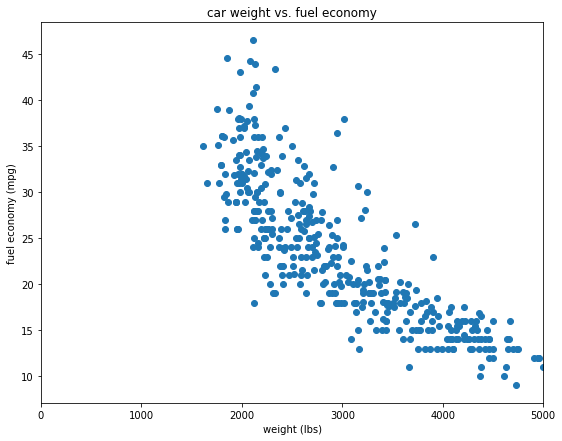

In [19]:
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter( cars.weight, cars.mpg )
ax.set_xlabel("weight (lbs)")
ax.set_ylabel("fuel economy (mpg)")
ax.set_title("car weight vs. fuel economy")
ax.set_xlim(0, 5000)

In [20]:
40 / 5

8.0

The "base" mpg, for a 0-pound car would be around 50 mpg, and the mpg drops to 10 for a 5000-pound car.

That's a 40 mpg drop for 5000 pounds, so that's 40 mpg / 5k lb = 8 mpg drop per 1k pound increase.

In [21]:
b = 50
m = 40/5000
fhat = lambda X: b - m*X

In [22]:
yhat = fhat(cars_test.weight)

In [23]:
yhat.iloc[0:10]

146    33.000
282    26.880
69     14.352
378    33.000
331    32.840
257    24.320
310    34.256
328    24.000
125    25.184
108    31.768
Name: weight, dtype: float64

In [24]:
mse = ((cars_test.mpg - yhat)**2).mean()
mse

27.826178256410255

A small improvement over the stepwise mean regression. Let's graph the predictions and residuals to give us a hint about how to pick better parameters:

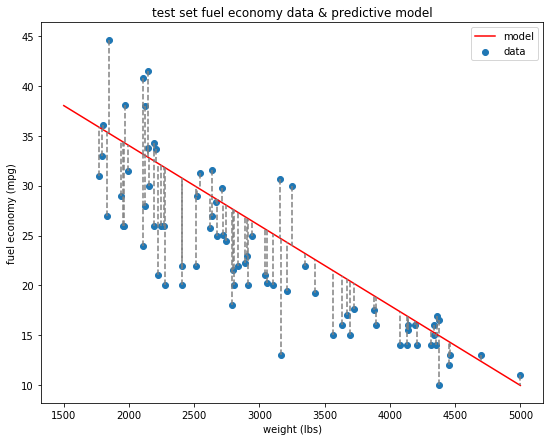

In [25]:
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter( cars_test.weight, cars_test.mpg, label="data" )
ax.set_xlabel("weight (lbs)")
ax.set_ylabel("fuel economy (mpg)")
ax.set_title("test set fuel economy data & predictive model")

weights = np.linspace(1500,5000)
ax.plot( weights, fhat(weights), c="red", label="model" )
ax.legend()

for x_i, y_i in zip(cars_test.weight,cars_test.mpg):
    plt.plot([x_i, x_i], [y_i, b-m*x_i], color='gray', linestyle='dashed')

A smaller $b$ would move the line down, shortening all the residuals below the red line.

In [26]:
b = 45
m = 40/5000
fhat = lambda X: b - m*X

yhat = fhat(cars_test.weight)

mse = ((cars_test.mpg - yhat)**2).mean()
mse

25.66156287179488

Another small improvement. Let's do this for a _lot_ of $b$ values to find the best one:

In [27]:
bs = np.linspace(40,55)
m = 40/5000

mses = []
for b in bs:
    fhat = lambda X: b - m*X

    yhat = fhat(cars_test.weight)

    mse = ((cars_test.mpg - yhat)**2).mean()
    mses.append( mse )

Text(0, 0.5, 'MSE')

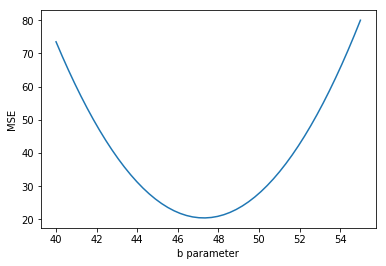

In [28]:
plt.plot( bs, mses )
plt.xlabel("b parameter")
plt.ylabel("MSE")

At this point we could use the techniques of convex optimization to find the optimal $b$, or simply find the argmin:

In [29]:
# best b parameter
best_b = bs[ np.argmin(mses) ]

In [30]:
m = 40/5000
fhat = lambda X: best_b - m*X

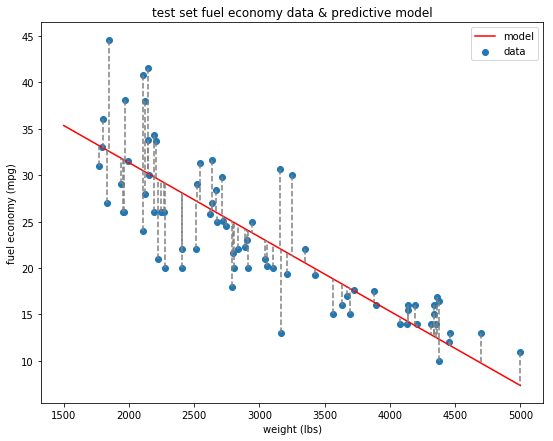

In [31]:
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter( cars_test.weight, cars_test.mpg, label="data" )
ax.set_xlabel("weight (lbs)")
ax.set_ylabel("fuel economy (mpg)")
ax.set_title("test set fuel economy data & predictive model")

weights = np.linspace(1500,5000)
ax.plot( weights, fhat(weights), c="red", label="model" )
ax.legend()

for x_i, y_i in zip(cars_test.weight,cars_test.mpg):
    plt.plot([x_i, x_i], [y_i, best_b-m*x_i], color='gray', linestyle='dashed')

## Linear regression as linear algebra

The intuitive model above 

$$\hat{y_i} = b - m \cdot x_i$$

Is a reexpression of the basic one-dimensional linear equation

$$\hat{y_i} = mx_i + b$$

We can express this as

$$\hat{y} = X\beta$$

where 
* $\hat{y_i}$ is the ith item in $\hat{y}$
* $(x_i, 1)$ is the ith row in $X$
* $\beta$ is $(m,b)$

This is a small notational convenience that will become a huge convenience soon.

#### A fun exercise which is also a lot of work
Show that the vector of parameter values $\beta$ that minimizes the SSR in the general case is the solution to the matrix equation

$$ X^T X \beta = X^T y $$
 
Which can also be written as $\beta = (X^TX)^{-1}X^T y$
 
Now we have a **closed-form solution for $\beta$ that minimizes MSE**.

(If you want to start work proving this very elegant identity, start by watching [this MIT lecture](https://ocw.mit.edu/courses/mathematics/18-06-linear-algebra-spring-2010/video-lectures/lecture-16-projection-matrices-and-least-squares/)).

Let's use it.

In [32]:
X = np.stack( [cars_train.weight.values, np.ones_like( cars_train.weight )] ).T
y = cars_train.mpg.values

In [33]:
beta = np.linalg.inv(X.T @ X) @ X.T @ y
beta

array([-7.72555665e-03,  4.64474768e+01])

In [34]:
m, b = beta
fhat = lambda X: m*X + b

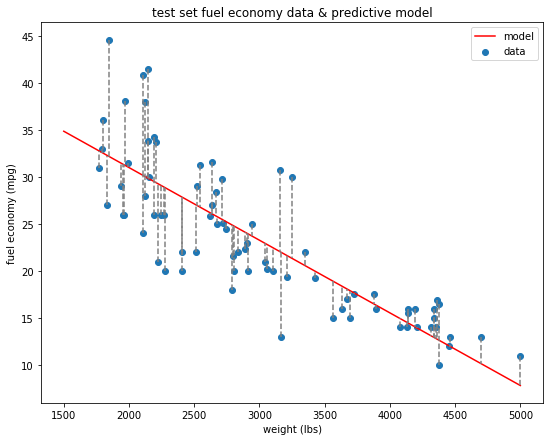

In [35]:
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter( cars_test.weight, cars_test.mpg, label="data" )
ax.set_xlabel("weight (lbs)")
ax.set_ylabel("fuel economy (mpg)")
ax.set_title("test set fuel economy data & predictive model")

weights = np.linspace(1500,5000)
ax.plot( weights, fhat(weights), c="red", label="model" )
ax.legend()

for x_i, y_i in zip(cars_test.weight,cars_test.mpg):
    plt.plot([x_i, x_i], [y_i, m*x_i+b], color='gray', linestyle='dashed')

In [36]:
yhat = fhat(cars_test.weight)
mse = ((cars_test.mpg - yhat)**2).mean()
mse

20.233704522903235

Stunning success!

## Linear regression on multiple predictors

As a notational convenience I coined:

$$\hat{y} = X\beta$$

We can generalize $X$ to a n by p+1 matrix, where row i corresponds to the ith sample, and column j corresponds to the jth predictor. Likewise $\beta$ is a vector of length p+1.

If we crack this open, it expands to:

$$ \hat{y_i} = \beta_0 \cdot 1 + \beta_1x_{i,1} + \beta_2x_{i,2} + ... + \beta_px_{i,p} $$

For example, 
* 0th column would be all 1s, 
* the 1st column of X holds the car weight, 
* the 2st column of X holds the cylinder displacement.

In this case the semantics of $\beta$ is:
* $\beta_0$ is the "base" car mpg
* $\beta_1$ is the mpg penalty for each pound of car
* $\beta_1$ is the mpg penalty for each cc of engine displacement

Let's trust the math and try it:

In [37]:
X = np.stack( [np.ones_like( cars_train.weight ),
               cars_train.weight.values, 
               cars_train.displacement.values] ).T
y = cars_train.mpg.values

In [38]:
beta = np.linalg.inv(X.T @ X) @ X.T @ y
beta

array([ 4.45024213e+01, -6.20848786e-03, -1.32975132e-02])

In [39]:
X_test = np.stack( [np.ones_like( cars_test.weight ),
               cars_test.weight.values, 
               cars_test.displacement.values] ).T
y_test = cars_test.mpg.values

In [40]:
((X_test @ beta - y_test)**2).mean()

19.394298320210208

A small improvement!

## Linear regression using categorical predictors

In the cars dataset, the feature `origin` corresponds to the _continent_ or origin.


In [41]:
cars.origin.value_counts()

1    245
3     79
2     68
Name: origin, dtype: int64

This looks like a numerical feature, but it isn't at all - the codes correspond to the USA, Europe, and Asia in increasing order. How do we use the tools of linear regression on a feature that's _not a number_?

One simple strategy is to create numerical "dummy variables" that encode the presence of a categorical feature with a 1.0.

In [42]:
cars["american"] = cars.origin.map( lambda x: 1.0 if x==1 else 0.0 )
cars["european"] = cars.origin.map( lambda x: 1.0 if x==2 else 0.0 )
cars["asian"] = cars.origin.map( lambda x: 1.0 if x==3 else 0.0 )

In [43]:
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name,american,european,asian
146,28.0,4,90.0,75.0,2125.0,14.5,74,1,dodge colt,1.0,0.0,0.0
282,22.3,4,140.0,88.0,2890.0,17.3,79,1,ford fairmont 4,1.0,0.0,0.0
69,12.0,8,350.0,160.0,4456.0,13.5,72,1,oldsmobile delta 88 royale,1.0,0.0,0.0
378,38.0,4,105.0,63.0,2125.0,14.7,82,1,plymouth horizon miser,1.0,0.0,0.0
331,33.8,4,97.0,67.0,2145.0,18.0,80,3,subaru dl,0.0,0.0,1.0


Now there exists a linear realtionship between the category-dummy and the target variable. For example as a car's "american" property goes to 1.0, the fuel economy goes down:

Text(0, 0.5, 'fuel economy (mpg)')

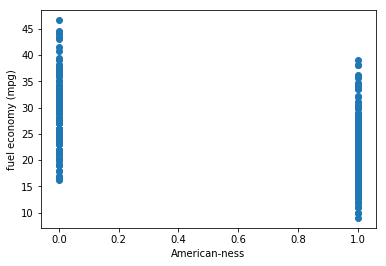

In [49]:
plt.scatter( cars.american, cars.mpg )
plt.xlabel( "American-ness" )
plt.ylabel( "fuel economy (mpg)")

In [50]:
cars_test = cars.iloc[:n_holdout]
cars_train = cars.iloc[n_holdout:]

X = np.stack( [np.ones_like( cars_train.weight ),
               cars_train.weight.values, 
               cars_train.displacement.values,
               cars_train.american.values] ).T
y = cars_train.mpg.values

beta = np.linalg.inv(X.T @ X) @ X.T @ y

X_test = np.stack( [np.ones_like( cars_test.weight ),
               cars_test.weight.values, 
               cars_test.displacement.values,
               cars_test.american.values] ).T
y_test = cars_test.mpg.values

((X_test @ beta - y_test)**2).mean()

18.82363367825335

Once again we were able to squeak out a small improvement on the test set.

## Engineered features: making curves out of straight lines

The relationship between weight and fuel economy is _not a straight line_. This makes sense if you think about it: the fuel economy of a car can never be negative - it will go to zero as the weight increases.

Text(0.5, 1.0, 'car weight vs. fuel economy')

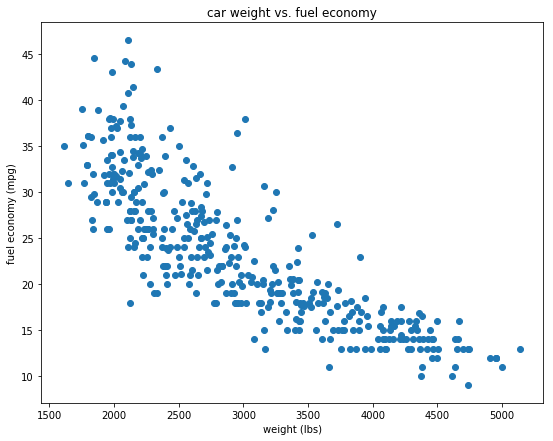

In [53]:
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter( cars.weight, cars.mpg )
ax.set_xlabel("weight (lbs)")
ax.set_ylabel("fuel economy (mpg)")
ax.set_title("car weight vs. fuel economy")

One solution is to perform linear regression on engineered features. One potential model:

$$y = \beta_0 + \frac{\beta_1}{x_{weight}}$$

might seem nonlinear, but it's simply a linear function of the predictor $\frac{1}{x_{weight}}$.

Text(0.5, 1.0, 'car weight vs. fuel economy')

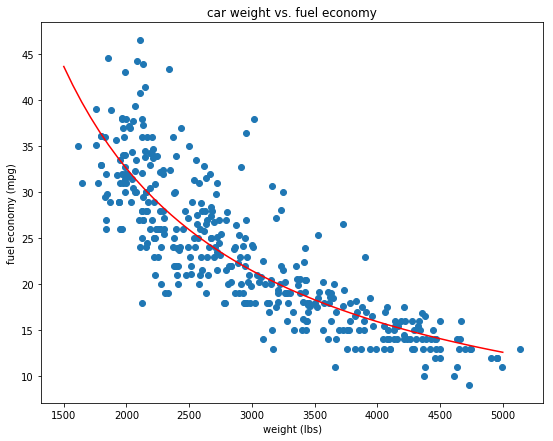

In [61]:
X = np.stack( [np.ones_like( cars_train.weight ),
               1/cars_train.weight.values] ).T
y = cars_train.mpg.values

beta = np.linalg.inv(X.T @ X) @ X.T @ y
beta

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter( cars.weight, cars.mpg )
weightspace = np.linspace(1500, 5000)
ax.plot( weightspace, beta[1]*(1/weightspace)+beta[0], c="red")
ax.set_xlabel("weight (lbs)")
ax.set_ylabel("fuel economy (mpg)")
ax.set_title("car weight vs. fuel economy")

One popular (if philosophically shakey) strategy for fitting complex curves is _polynomial regression_, which involves creating polynomial features from observed features.

Text(0.5, 1.0, 'car weight vs. fuel economy')

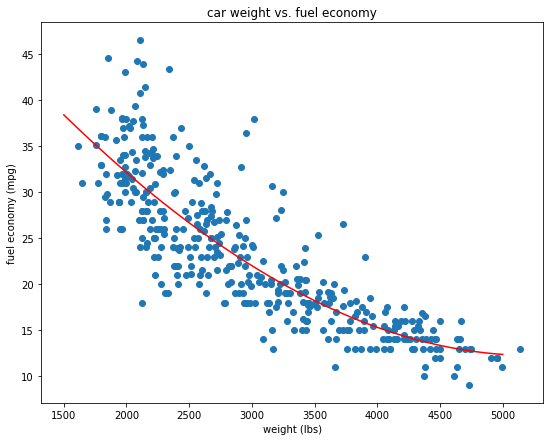

In [69]:
# going up to cubic features

X = np.stack( [np.ones_like( cars_train.weight ),
               cars_train.weight.values**1,
               cars_train.weight.values**2,
               cars_train.weight.values**3] ).T
y = cars_train.mpg.values

beta = np.linalg.inv(X.T @ X) @ X.T @ y

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter( cars.weight, cars.mpg )
weightspace = np.linspace(1500, 5000)
fake_feats = np.stack( [np.ones_like(weightspace), 
                        weightspace**1, 
                        weightspace**2, 
                        weightspace**3] ).T
ax.plot( weightspace, fake_feats @ beta, c="red")
ax.set_xlabel("weight (lbs)")
ax.set_ylabel("fuel economy (mpg)")
ax.set_title("car weight vs. fuel economy")

## Cross-validation for hyperparameter selection

It is possible to go overboard with polynomial features, leading to poor generalization on the test set:

Text(0.5, 1.0, 'car weight vs. fuel economy')

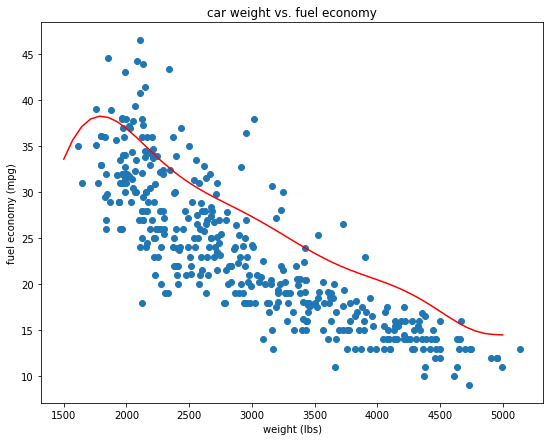

In [86]:
order = 10

features = [np.ones_like( cars_train.weight )]
for i in range(1,order+1):
    features.append( cars_train.weight.values**i )
X = np.stack( features ).T
y = cars_train.mpg.values

beta = np.linalg.inv(X.T @ X) @ X.T @ y

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter( cars.weight, cars.mpg )
weightspace = np.linspace(1500, 5000)
fake_feats = [np.ones_like(weightspace)]
for i in range(1,order+1):
    fake_feats.append( weightspace**i )
fake_feats = np.stack( fake_feats ).T
ax.plot( weightspace, fake_feats @ beta, c="red")
ax.set_xlabel("weight (lbs)")
ax.set_ylabel("fuel economy (mpg)")
ax.set_title("car weight vs. fuel economy")

Text(0.5, 1.0, 'Polynomial out of sample error')

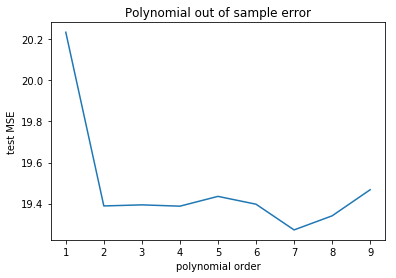

In [98]:
orders = range(1, 10)
mses = []
for order in orders:

    features = [np.ones_like( cars_train.weight )]
    for i in range(1,order+1):
        features.append( cars_train.weight.values**i )
    X = np.stack( features ).T
    y = cars_train.mpg.values

    beta = np.linalg.inv(X.T @ X) @ X.T @ y

    features = [np.ones_like( cars_test.weight )]
    for i in range(1,order+1):
        features.append( cars_test.weight.values**i )
    X_test = np.stack( features ).T

    test_mse = ((X_test @ beta - y_test)**2).mean()
    mses.append( test_mse )

plt.plot( orders, mses )
plt.xlabel("polynomial order")
plt.ylabel("test MSE")
plt.title("Polynomial out of sample error")

## In practice: linear regression using `sklearn`

Mostly we just use helper functions to do all of this:

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Put together feature matrix and target vector

In [102]:
X = cars[["cylinders", "displacement", "horsepower", "weight", "acceleration", "american", "european", "asian"]]
y = cars["mpg"]

Do train test split

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

Fit using training set.

In [107]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Predict using the test features.

In [108]:
yhat = model.predict( X_test )

Evaluate against the test target.

In [111]:
mean_squared_error(y_test, yhat)

16.532335022365015

## Jumping ahead: inference

Jack will talk about these tomorrow; they are assumptions that must hold in order to use linear regression for _inference_. Tomorrow!

### Linearity: violated when you see nonlinear trends in your data /  residuals

### Homoscedasticity: violated when the variance of your residuals isn't constant

### Normality: violated when the residuals are not normally distributed

### Multicollinearity: strictly violated when one feature is a linear combination of others, loosely violated when one feature is highly correlated with others
